In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_Yuming/codes')

Mounted at /content/drive


In [2]:
%%capture
!pip install ipython-autotime
!pip install torchdiffeq
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
!pip install latex
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super
%load_ext autotime
%matplotlib inline

time: 1.32 ms (started: 2021-07-05 08:47:21 +00:00)


In [3]:
import utils
from core_training import train_loop_diff, train_loop_em_new
from viz_loss import loss_grad_vis_1d, loss_grad_vis_2d
# from tqdm import tqdm
from tqdm.auto import tqdm

from models import DEModel, DAModel, NNModel, Noise

# reflect real-time changes in other modules
import importlib
importlib.reload(utils)
importlib.reload(DEModel)
importlib.reload(DAModel)
importlib.reload(NNModel)
importlib.reload(Noise)

from utils import Timer
import copy
import math
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.integrate import solve_ivp
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"
print(f"device: {device}")

device: cuda:0
time: 7.46 s (started: 2021-07-05 08:47:21 +00:00)


In [ ]:
torch.backends.cudnn.benchmark = True

time: 2.1 ms (started: 2021-06-27 19:58:18 +00:00)


In [4]:
importlib.reload(sys.modules['core_training'])
importlib.reload(NNModel)
importlib.reload(DAModel)
from core_training import train_loop_diff, train_loop_em_new


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for nm in range(1):
  x_dim = 40
  true_F = 8.
  true_coeff = torch.tensor([8., 0., 0., -1, 0., 0., 0., 0., 0., 0., 0., -1., 0., 0., 0., 0., 1., 0.], device=device)
  true_ode_func = NNModel.Lorenz96(F=true_F, x_dim=x_dim, device=device).to(device)

  init_m = torch.zeros(x_dim, device=device)
  init_C_param = Noise.AddGaussian(x_dim, 50*torch.eye(x_dim), 'full').to(device)

  train_and_test = 12
  train_size = 8

  with torch.no_grad():
    u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim), covariance_matrix=25 * torch.eye(x_dim)).sample().to(device) # <-
    t_warmup = torch.cat((torch.tensor([0.]), 120*torch.arange(1, train_and_test+1))).to(device)
    out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
    u0 = out_warmup[1:]  # (*bs, x_dim)

  t0 = 0.
  t_obs_step = 0.05
  t_obs_end = 60.
  t_obs = torch.arange(t0, t_obs_end+t_obs_step, t_obs_step)[1:].to(device)

  model_Q_true = None

  indices = [i for i in range(x_dim)] if nm == 0 else ( [3 * i for i in range(14)] + [3 * i + 1 for i in range(13)] )
  # indices = [3 * i for i in range(14)] + [3 * i + 1 for i in range(13)]
  # indices = [2 * i for i in range(20)]
  y_dim = len(indices)
  time_varying_obs = False
  if time_varying_obs:
    true_obs_func = []
    for j in range(t_obs.shape[0]):
      indices = np.random.choice(x_dim, y_dim, False)
      H_true = torch.eye(x_dim)[indices]
      true_obs_func.append(NNModel.Linear(x_dim, y_dim, H=H_true).to(device))
  else:    
    H_true = torch.eye(x_dim)[indices]
    true_obs_func = NNModel.Linear(x_dim, y_dim, H=H_true).to(device)

  noise_R_true = Noise.AddGaussian(y_dim, torch.tensor(1.), param_type='scalar').to(device)

  with torch.no_grad():
    out, y_obs, out_intermediate, t_intermediate = DEModel.generate_data(true_ode_func, true_obs_func, t_obs, u0, model_Q_true, noise_R_true, 
                                                  device=device, ode_method='rk4', ode_options=dict(step_size=0.01), adjoint=False, save_intermediate_step=True, t0=0., time_varying_obs=time_varying_obs)
    

  enkf_kwargs = dict(ode_method='rk4', ode_options=dict(step_size=0.01), adjoint=True, adjoint_method='rk4', adjoint_options=dict(step_size=0.05),save_intermediate_step=True, smooth_lag=0, t0=t0, 
            var_inflation=None, localization_radius=5, compute_likelihood=True, likelihood_warmup=0, 
            linear_obs=True, time_varying_obs=time_varying_obs, save_first=True, simulation_type=0)

  with torch.no_grad():
    u0_warmup = torch.distributions.MultivariateNormal(torch.zeros(x_dim), covariance_matrix=25 * torch.eye(x_dim)).sample((100,)).to(device) # <-
    t_warmup = torch.cat((torch.tensor([0.]), torch.arange(80.,880.,20.))).to(device)
    out_warmup = odeint(true_ode_func, u0_warmup, t_warmup, method='rk4', options=dict(step_size=0.05))
    u0_test = out_warmup[1:].reshape(-1,x_dim)  # (*bs, x_dim)
    print(u0_test.shape)

  def monitor(ode_func, model_Q_param,noise_R_param, neg_log_likelihood, test_neg_log_likelihood, test_mse, fs, nll_suro_em, algorithm, device):
    res = torch.zeros(0, device=device)
    # res = torch.cat((res, utils.mse_loss(ode_func.coeff, true_coeff).detach().clone().view(-1)))
    # res = torch.cat((res, ode_func.coeff.detach().clone().view(-1)))
    # res = torch.cat((res, model_Q_param.q_true().detach().clone().view(-1)))
    res = torch.cat((res, torch.sqrt(torch.diagonal(model_Q_param.full(), dim1=-2, dim2=-1).mean()).detach().clone().view(-1)))
    res = torch.cat((res, neg_log_likelihood.mean().detach().clone().view(-1)))
    res = torch.cat((res, test_neg_log_likelihood.mean().detach().clone().view(-1)))
    res = torch.cat((res, test_mse.detach().clone().view(-1)))
    res = torch.cat((res, fs.detach().clone().view(-1)))
    return res.unsqueeze(dim=0)

  Q_list = 2*torch.ones(x_dim, device=device).unsqueeze(0).repeat(2,1)
  pert_0, pert_1, pert_2 = 1, 0.1, 0.01
  pert_diag = torch.cat( (pert_0 * torch.ones(1), pert_1 * torch.ones(5), pert_2 * torch.ones(12)) ).to(device)
  pert_cov = torch.diag(pert_diag)
  pert = torch.distributions.MultivariateNormal(torch.zeros(18,device=device), covariance_matrix=pert_cov).sample()
  init_coeff = true_coeff + pert

  n_runs=3

  N_ensem = 50
  save = False
  save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/"
  prefix = f"N_{N_ensem}_x_{x_dim}_y_{y_dim}_diag_3_"

  seed = 54
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)


  # lambda1 = lambda epoch: (epoch-9)**(-0.75) if epoch >=10 else 1
  # lambda2 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1

  # enkf_kwargs['likelihood_warmup']=20
  # monitor_EnKF = torch.zeros(0, device=device)
  # for iter in range(n_runs):#iter in range(1):
  #   print(f"iter={iter}")
  #   learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
  #   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
  #   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[iter].detach().clone()*torch.eye(x_dim,device=device), 'tril').to(device)
  #   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-3},
  #                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  #   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
  #   # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
  #   # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i for i in range(10,50)], gamma=0.9)
  #   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 1 if epoch >= 10 else 1, lambda epoch: 1 if epoch >= 10 else 1])
  #   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
  #   monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=76, 
  #                                 scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=10, test_every_n_epochs=1,test_filter=True, tbptt=20, method='enkf', train_size=train_size, clip_norm=None, 
  #                                 true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
  #   monitor_EnKF = torch.cat((monitor_EnKF, monitor_res.unsqueeze(0)))

  # if save:
  #   torch.save({'monitor': monitor_EnKF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EnKF")


  # lambda1 = lambda epoch: (epoch-9)**(-1) if epoch >=10 else 1

  # enkf_kwargs['likelihood_warmup']=20
  # enkf_kwargs['smooth_lag']=0.2
  # # enkf_kwargs['adjoint']=False
  # monitor_EM = torch.zeros(0, device=device)
  # for iter in range(n_runs):
  #   print(f"iter={iter}")
  #   learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
  #   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
  #   # learned_model_Q = utils.softplus_inv(0.1*torch.ones(x_dim, device=device))
  #   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-3}])
  #                             #  {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  #   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
  #   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 0.99 if epoch >= 10 else 1])
  #   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
  #   monitor_res, learned_model_Q = train_loop_em_new(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, 200, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer, n_epochs=76, 
  #                               scheduler=scheduler, batch_length=120, bs=1, print_every_n_epochs=10, test_every_n_epochs=1,test_filter=True, train_size=train_size, m_step_type="mean", m_steps=3,
  #                               track_Q='diag', true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
  #   monitor_EM = torch.cat((monitor_EM, monitor_res.unsqueeze(0)))

  # if save:
  #   torch.save({'monitor': monitor_EM, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"EM")

  # lambda1 = lambda epoch: (epoch-9)**(-0.75) if epoch >=10 else 1
  # lambda2 = lambda epoch: (epoch-9)**(-0.5) if epoch >=10 else 1

  # enkf_kwargs['likelihood_warmup']=20
  # monitor_PF = torch.zeros(0, device=device)
  # for iter in range(n_runs):#iter in range(1):
  #   print(f"iter={iter}")
  #   learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
  #   learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
  #   # learned_model_Q = Noise.AddGaussian(x_dim, Q_list[iter].detach().clone()*torch.eye(x_dim,device=device), 'tril').to(device)
  #   optimizer = torch.optim.Adam([{'params':learned_ode_func.parameters(), 'lr':1e-3},
  #                             {'params':learned_model_Q.parameters(), 'lr':1e-1}])
  #   # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
  #   # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
  #   # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i for i in range(10,50)], gamma=0.9)
  #   # scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=[lambda epoch: 1 if epoch >= 10 else 1, lambda epoch: 1 if epoch >= 10 else 1])
  #   scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])
  #   monitor_res = train_loop_diff(learned_ode_func, true_obs_func, t_obs, y_obs, out, out_intermediate, N_ensem, init_m, init_C_param, learned_model_Q, noise_R_true, device, optimizer,proposal='optimal', adaptive_resampling=False, n_epochs=76, 
  #                                 scheduler=scheduler, batch_length=30, bs=1, print_every_n_epochs=10, test_every_n_epochs=1,test_filter=True, tbptt=20, method='pf', train_size=train_size, clip_norm=None, 
  #                                 true_system="L96", true_ode_func=true_ode_func, u0_test=u0_test, monitor=monitor, timer=True, lr_decay=None,**enkf_kwargs)
  #   monitor_PF = torch.cat((monitor_PF, monitor_res.unsqueeze(0)))

  # if save:
  #   torch.save({'monitor': monitor_PF, 'learned_ode_func':learned_ode_func.state_dict(), 'learned_model_Q':learned_model_Q.state_dict()},save_location+prefix+"PF")

torch.Size([4000, 40])
time: 32.6 s (started: 2021-07-05 08:47:28 +00:00)


In [ ]:
init_coeff

tensor([ 6.1450,  0.6479,  0.4404, -1.6152, -1.1102,  0.3842,  0.2622, -0.2339,
         0.1906, -0.4743,  0.2828, -0.5888, -0.2854,  0.3293, -0.0818, -0.9092,
         0.4033,  0.4612], device='cuda:0')

time: 24.1 ms (started: 2021-06-15 16:34:48 +00:00)


In [ ]:
Q_list = 2*torch.ones(x_dim, device=device).unsqueeze(0).repeat(2,1)
pert_0, pert_1, pert_2 = 1, 0.1, 0.01
# pert_0, pert_1, pert_2 = 0.5, 0.5, 0.5
pert_diag = torch.cat( (pert_0 * torch.ones(1), pert_1 * torch.ones(5), pert_2 * torch.ones(12)) ).to(device)
pert_cov = torch.diag(pert_diag)
pert = torch.distributions.MultivariateNormal(torch.zeros(18,device=device), covariance_matrix=pert_cov).sample()
init_coeff = true_coeff + pert
learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)

time: 12.8 ms (started: 2021-06-15 03:52:18 +00:00)


In [8]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_3_EnKF")
monitor_EnKF = d_EnKF['monitor']
# learned_ode_func = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func.load_state_dict(d_EnKF['learned_ode_func'])
learned_model_Q.load_state_dict(d_EnKF['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[241:], out[240:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.2339, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(-69771.6250, device='cuda:0') tensor(-69503.7656, device='cuda:0')
time: 31.5 s (started: 2021-07-05 08:49:37 +00:00)


In [ ]:
utils.plot_filter(t_obs[:200], out[:200,8], X_track_test[1:201,0], name="Ensemble", plot_all=False, compare_F_S=False, fig_num_limit=5)

In [ ]:
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_3_EM")
monitor_EM = d_EM['monitor']
# learned_ode_func = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func.load_state_dict(d_EM['learned_ode_func'])
learned_model_Q.load_state_dict(d_EM['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[241:], out[240:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.3980, device='cuda:0')
tensor(0.2133, device='cuda:0')
tensor(-72391.7891, device='cuda:0') tensor(-69514.8906, device='cuda:0')
time: 30.8 s (started: 2021-06-27 20:08:12 +00:00)


In [ ]:
d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_3_PF")
monitor_PF = d_PF['monitor']
# learned_ode_func = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_ode_func = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
learned_model_Q = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func.load_state_dict(d_PF['learned_ode_func'])
learned_model_Q.load_state_dict(d_PF['learned_model_Q'])


small_Q = Noise.AddGaussian(x_dim, torch.tensor(math.sqrt(0.01),device=device), param_type='scalar')
with torch.no_grad():
  _, _, X_track_test, _, w_track_test, _, test_neg_log_likelihood = DAModel.BootstrapPF(learned_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q, noise_R_true, device, 'optimal', False, **enkf_kwargs) 
  _, _, X_track_test2, _, w_track_test2, _, test_neg_log_likelihood2 = DAModel.BootstrapPF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 1000, init_m, init_C_param, small_Q, noise_R_true, device, 'optimal', False, **enkf_kwargs) 

print(torch.sqrt(utils.particle_mse_loss(X_track_test[241:], out[240:,8:], w_track_test[241:])))
print(torch.sqrt(utils.particle_mse_loss(X_track_test2[241:], out[240:,8:], w_track_test2[241:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.6574, device='cuda:0')
tensor(3.9391, device='cuda:0')
tensor(-79213.1719, device='cuda:0') tensor(-462362.1875, device='cuda:0')
time: 30.6 s (started: 2021-06-27 20:07:11 +00:00)


In [10]:
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_2_EnKF")
monitor_EnKF_f = d_EnKF['monitor']
learned_ode_func_f = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_model_Q_f = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func_f.load_state_dict(d_EnKF['learned_ode_func'])
learned_model_Q_f.load_state_dict(d_EnKF['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func_f, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q_f, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[241:], out[240:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.2453, device='cuda:0')
tensor(0.2122, device='cuda:0')
tensor(-69905.3906, device='cuda:0') tensor(-69500.5625, device='cuda:0')
time: 26.1 s (started: 2021-07-05 08:51:26 +00:00)


In [ ]:
d_EM = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_2_EM")
monitor_EM_f = d_EM['monitor']
learned_ode_func_f = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_model_Q_f = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func_f.load_state_dict(d_EM['learned_ode_func'])
learned_model_Q_f.load_state_dict(d_EM['learned_model_Q'])

with torch.no_grad():
  _, X_track_test, _, test_neg_log_likelihood = DAModel.EnKF(learned_ode_func_f, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q_f, noise_R_true, device, **enkf_kwargs) 
  _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 

print(torch.sqrt(utils.mse_loss(X_track_test.mean(dim=-2)[241:], out[240:,8:])))
print(torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(0.3998, device='cuda:0')
tensor(0.2121, device='cuda:0')
tensor(-72454.7891, device='cuda:0') tensor(-69510.8281, device='cuda:0')
time: 25 s (started: 2021-06-27 20:09:41 +00:00)


In [ ]:
d_PF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/N_50_x_40_y_40_diag_2_PF")
monitor_PF_f = d_PF['monitor']
# learned_ode_func = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_ode_func_f = NNModel.Lorenz96_correction(init_coeff.detach().clone(), device, x_dim).to(device)
learned_model_Q_f = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func_f.load_state_dict(d_PF['learned_ode_func'])
learned_model_Q_f.load_state_dict(d_PF['learned_model_Q'])


small_Q = Noise.AddGaussian(x_dim, torch.tensor(math.sqrt(0.01),device=device), param_type='scalar')
with torch.no_grad():
  _, _, X_track_test, _, w_track_test, _, test_neg_log_likelihood = DAModel.BootstrapPF(learned_ode_func_f, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, learned_model_Q_f, noise_R_true, device, 'optimal', False, **enkf_kwargs) 
  _, _, X_track_test2, _, w_track_test2, _, test_neg_log_likelihood2 = DAModel.BootstrapPF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 1000, init_m, init_C_param, small_Q, noise_R_true, device, 'optimal', False, **enkf_kwargs) 

print(torch.sqrt(utils.particle_mse_loss(X_track_test[241:], out[240:,8:], w_track_test[241:])))
print(torch.sqrt(utils.particle_mse_loss(X_track_test2[241:], out[240:,8:], w_track_test2[241:])))
print(test_neg_log_likelihood.mean(), test_neg_log_likelihood2.mean())

tensor(1.0214, device='cuda:0')
tensor(3.9183, device='cuda:0')
tensor(-103458.6094, device='cuda:0') tensor(-450298.2188, device='cuda:0')
time: 31.1 s (started: 2021-06-27 20:15:56 +00:00)


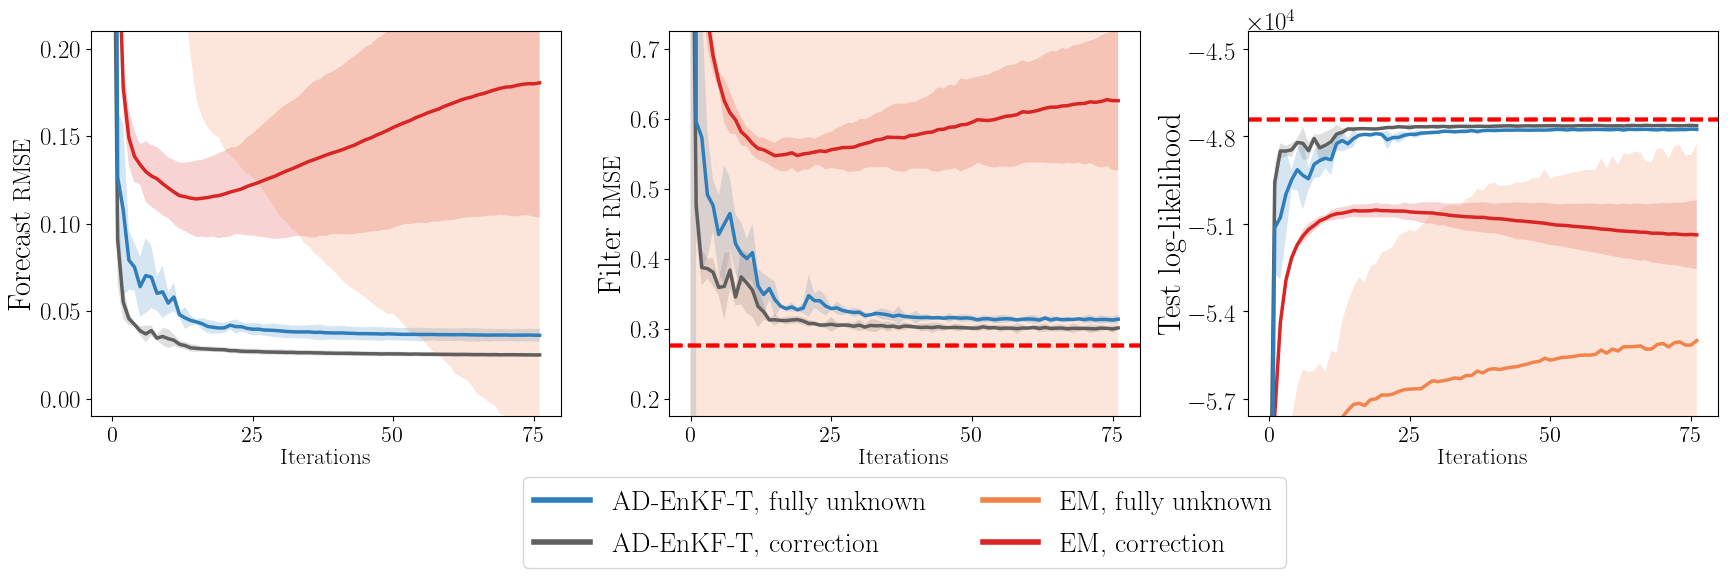

time: 1.41 s (started: 2021-06-27 00:09:44 +00:00)


In [ ]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20


def custom_axes(axes, ax_d):
  axes[0,0].set_xlabel(r"Iterations", fontsize=17)
  axes[0,0].set_ylabel(r"Forecast {\LARGE RMSE}")
  axes[0,1].set_xlabel(r"Iterations", fontsize=17)
  axes[0,1].set_ylabel(r"Filter {\LARGE RMSE}")
  axes[0,2].set_xlabel(r"Iterations", fontsize=17)
  axes[0,2].set_ylabel(r"Test log-likelihood")

  utils.set_lim_ticks(axes[0,0], 0.0, 0.2, 5)
  utils.set_lim_ticks(axes[0,1], 0.2, 0.7, 6)
  utils.set_lim_ticks(axes[0,2], -57000, -45000, 5)
  axes[0,2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

  axes[0,0].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,1].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,2].xaxis.set_ticks(np.linspace(0, 75, 4))
  # axes[0,0].yaxis.set_major_locator(plt.MaxNLocator(9))
  # axes[0,1].yaxis.set_major_locator(plt.MaxNLocator(7))


  axes[0,0].get_legend().remove()
  handles, labels = utils.unique_labels(axes[0,1])
  legend_order=[1,0,3,2]
  leg=axes[0,1].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower center',bbox_to_anchor=(0.5, -0.43), ncol=2)
  
  axes[0,2].get_legend().remove()
  for line in leg.get_lines():
    line.set_linewidth(4.0)
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_EnKF_new_f=monitor_EnKF_f.detach().clone()
monitor_EM_new_f=monitor_EM_f.detach().clone()[torch.tensor([0,1,2,3,4,5],dtype=torch.long)]
# monitor_EnKF_new = torch.cat((monitor_EnKF_new, utils.flat2matrix(monitor_EnKF_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EM_new = torch.cat((monitor_EM_new, utils.flat2matrix(monitor_EM_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EnKF_new[:,:,0]=torch.abs(monitor_EnKF_new[:,:,0]-monitor_KF_truths[0])
# with torch.no_grad():
#   _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 
# rmsea = torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])).item()
# test_ELBO = test_neg_log_likelihood2.mean().item()

save_location=None
load_location=None
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/learn_partial"
# torch.save({'rmsea':rmsea, 'test_ELBO':test_ELBO, 'init_coeff':init_coeff}, save_location+"_truth")
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_EnKF_new,monitor_EM_new, monitor_EnKF_new_f, monitor_EM_new_f]#,monitor_PF-monitor_KF]
# monitor_res = [(monitor_EnKF-monitor_KF)/torch.abs(monitor_KF),(monitor_PF-monitor_KF)/torch.abs(monitor_KF)]
# methods = [ r"Truth",r"EnKF",  r"PF",]
methods = [ r"AD-EnKF-T, correction", r"EM, correction", r"AD-EnKF-T, fully unknown",r"EM, fully unknown"]
# titles = ["ELBO", "test ELBO", "Filter RMSE", "Forecast RMSE"]
titles = [None] * 20
# truths = [None,math.sqrt(0.5),None,0.42,math.sqrt(0.01),None]
truths2 = [None] * 20
truths2_legends = ['t','t',None,'t','t',None]
# truths2 = [None, monitor_KF_truths[1]**2, monitor_KF_truths[2]] + [None, monitor_KF_truths[4]**2, monitor_KF_truths[5]]
truths = [None] * 20
truths[2], truths[3] = test_ELBO, rmsea
truths_legends = None
colors_list = [cm.Greys, cm.Reds, cm.Blues, cm.plasma]


groups = None
# plots_to_show = {0, 1, 2, 3, 5, 6, 7, 8}
plots_to_show = [7,3,2]
logscale={}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, legend_order=legend_order, groups=groups, start_from_one={}, plot_truth_first=True, colors_list=colors_list,
                           subplots_adjust=0.23,error_bar=True, error_bar_style="std", n_cols=3,subplot_width=7, subplot_height=5,linewidth=2.5, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

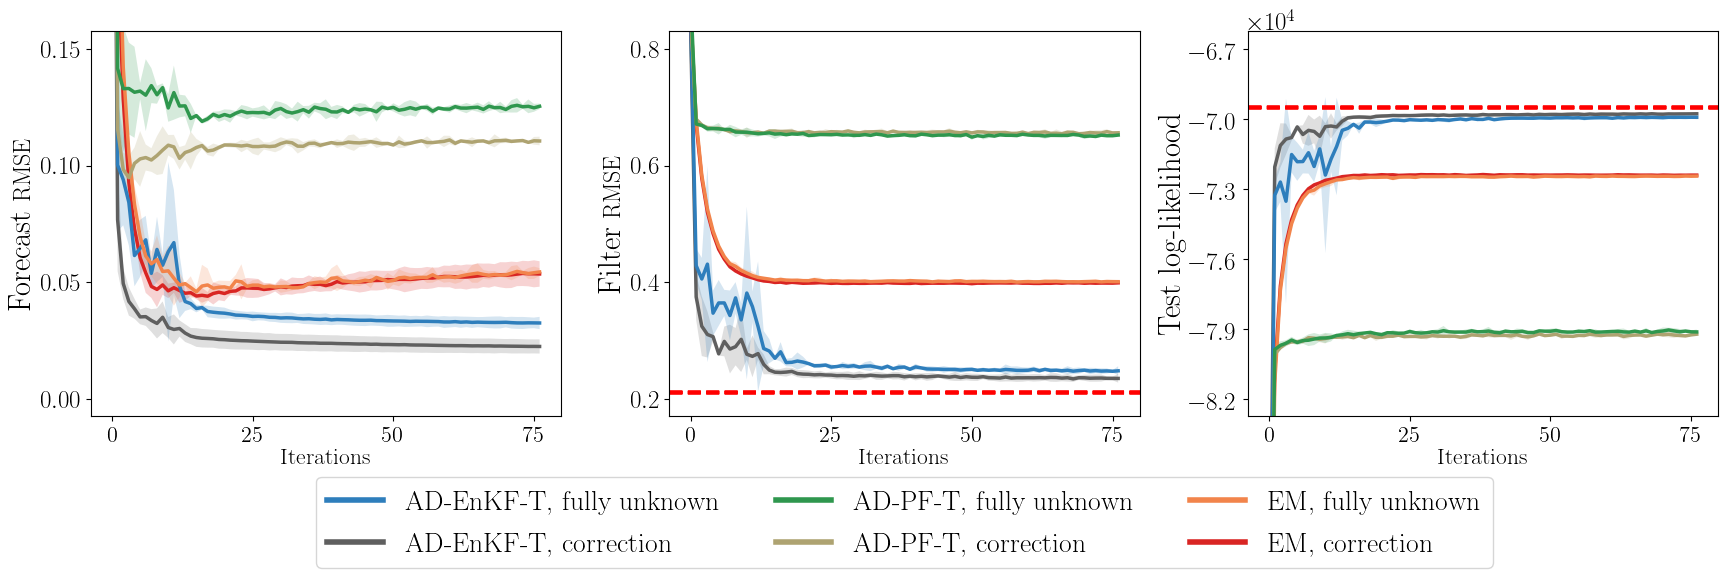

time: 924 ms (started: 2021-06-27 20:25:22 +00:00)


In [ ]:
importlib.reload(utils)

mpl.rc_file_defaults()
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['axes.titlesize']= 24
mpl.rcParams['axes.grid']= False
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize']= 18
mpl.rcParams['legend.fontsize']= 20


def custom_axes(axes, ax_d):
  axes[0,0].set_xlabel(r"Iterations", fontsize=17)
  axes[0,0].set_ylabel(r"Forecast {\LARGE RMSE}")
  axes[0,1].set_xlabel(r"Iterations", fontsize=17)
  axes[0,1].set_ylabel(r"Filter {\LARGE RMSE}")
  axes[0,2].set_xlabel(r"Iterations", fontsize=17)
  axes[0,2].set_ylabel(r"Test log-likelihood")

  utils.set_lim_ticks(axes[0,0], 0.0, 0.15, 4)
  utils.set_lim_ticks(axes[0,1], 0.2, 0.8, 4)
  utils.set_lim_ticks(axes[0,2], -82000, -67000, 6)
  axes[0,2].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

  axes[0,0].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,1].xaxis.set_ticks(np.linspace(0, 75, 4))
  axes[0,2].xaxis.set_ticks(np.linspace(0, 75, 4))
  # axes[0,0].yaxis.set_major_locator(plt.MaxNLocator(9))
  # axes[0,1].yaxis.set_major_locator(plt.MaxNLocator(7))


  axes[0,0].get_legend().remove()
  handles, labels = utils.unique_labels(axes[0,1])
  legend_order=[1,0,3,2,5,4]
  leg=axes[0,1].legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order], loc='lower center',bbox_to_anchor=(0.5, -0.43), ncol=3)
  
  axes[0,2].get_legend().remove()
  for line in leg.get_lines():
    line.set_linewidth(4.0)
  return

# monitor_KF_truths=monitor_KF[0,-1,:]
monitor_EnKF_new=monitor_EnKF.detach().clone()
monitor_EM_new=monitor_EM.detach().clone()
monitor_PF_new=monitor_PF.detach().clone()
monitor_EnKF_new_f=monitor_EnKF_f.detach().clone()
monitor_EM_new_f=monitor_EM_f.detach().clone()
monitor_PF_new_f=monitor_PF_f.detach().clone()
# monitor_EnKF_new = torch.cat((monitor_EnKF_new, utils.flat2matrix(monitor_EnKF_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EM_new = torch.cat((monitor_EM_new, utils.flat2matrix(monitor_EM_new[:,:,3:12], truth=model_Q_true.full()).unsqueeze(-1)), dim=-1)
# monitor_EnKF_new[:,:,0]=torch.abs(monitor_EnKF_new[:,:,0]-monitor_KF_truths[0])
# with torch.no_grad():
#   _, X_track_test2, _, test_neg_log_likelihood2 = DAModel.EnKF(true_ode_func, true_obs_func, t_obs, y_obs[:,8:], 100, init_m, init_C_param, model_Q_true, noise_R_true, device, **enkf_kwargs) 
# rmsea = torch.sqrt(utils.mse_loss(X_track_test2.mean(dim=-2)[241:], out[240:,8:])).item()
# test_ELBO = test_neg_log_likelihood2.mean().item()

save_location=None
load_location=None
save_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96new/learn_wPF"
# torch.save({'rmsea':rmsea, 'test_ELBO':test_ELBO, 'init_coeff':init_coeff}, save_location+"_truth")
# load_location = f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Linear/param_est"

# monitor_res = [monitor_KF,monitor_EnKF, monitor_PF]
monitor_res = [monitor_EnKF_new,monitor_EM_new, monitor_EnKF_new_f, monitor_EM_new_f, monitor_PF_new,monitor_PF_new_f]#,monitor_PF-monitor_KF]
# monitor_res = [(monitor_EnKF-monitor_KF)/torch.abs(monitor_KF),(monitor_PF-monitor_KF)/torch.abs(monitor_KF)]
# methods = [ r"Truth",r"EnKF",  r"PF",]
methods = [ r"AD-EnKF-T, correction", r"EM, correction", r"AD-EnKF-T, fully unknown",r"EM, fully unknown", r"AD-PF-T, correction",r"AD-PF-T, fully unknown"]
# titles = ["ELBO", "test ELBO", "Filter RMSE", "Forecast RMSE"]
titles = [None] * 20
# truths = [None,math.sqrt(0.5),None,0.42,math.sqrt(0.01),None]
truths2 = [None] * 20
truths2_legends = ['t','t',None,'t','t',None]
# truths2 = [None, monitor_KF_truths[1]**2, monitor_KF_truths[2]] + [None, monitor_KF_truths[4]**2, monitor_KF_truths[5]]
truths = [None] * 20
truths[2], truths[3] = test_ELBO, rmsea
truths_legends = None
colors_list = [cm.Greys, cm.Reds, cm.Blues, cm.plasma, cm.cividis, cm.Greens]


groups = None
# plots_to_show = {0, 1, 2, 3, 5, 6, 7, 8}
plots_to_show = [7,3,2]
logscale={}#{0,1,2}
logscalex={}
legend_order=None
utils.plot_monitor_res_new(monitor_res, methods, titles, truths, logscale, logscalex, truths_legends=truths_legends, truths2=truths2, truths2_legends=truths2_legends, legend_order=legend_order, groups=groups, start_from_one={}, plot_truth_first=True, colors_list=colors_list,
                           subplots_adjust=0.23,error_bar=True, error_bar_style="std", n_cols=3,subplot_width=7, subplot_height=5,linewidth=2.5, plots_to_show=plots_to_show, x_axiss=None, custom_axes=custom_axes, save_location=save_location, load_location=load_location)

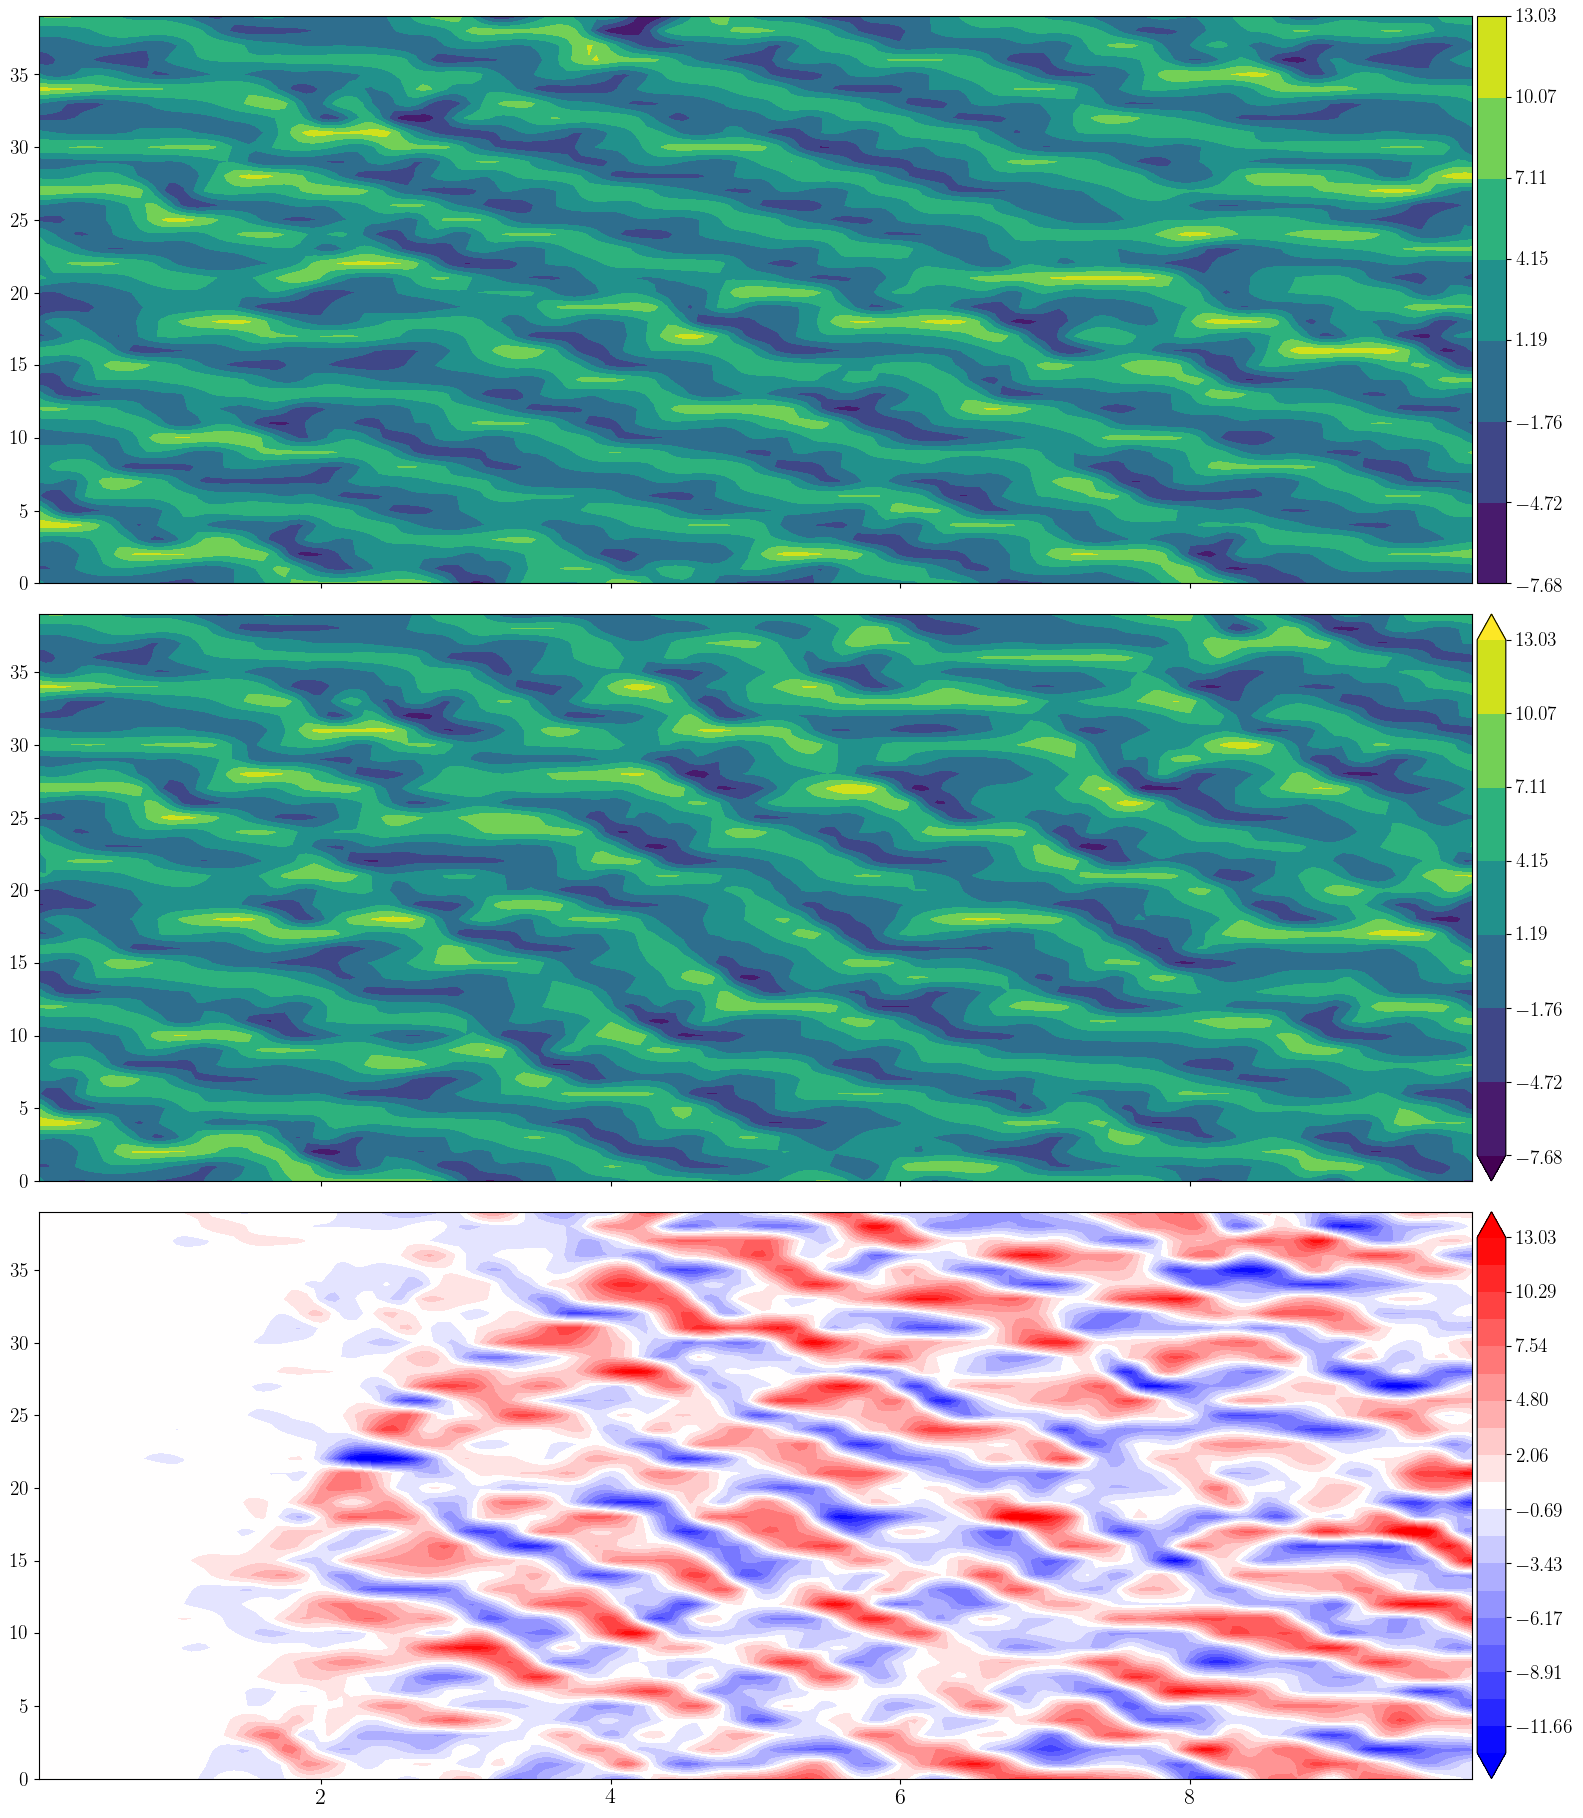

time: 9.2 s (started: 2021-06-25 20:41:28 +00:00)


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t_obs_test = torch.arange(0.05, 10, 0.05, device=device)
rdn = 5 #random.randrange(u0_test.shape[0])
out_test1, _, _, _ = DEModel.generate_data(learned_ode_func, None, t_obs_test, u0_test[rdn], None, None, device, ode_method='rk4', ode_options=dict(step_size=0.01),adjoint=False, save_intermediate_step=False)
out_test_true1, _, _, _ = DEModel.generate_data(true_ode_func, None, t_obs_test, u0_test[rdn], None, None, device, ode_method='rk4', ode_options=dict(step_size=0.01),adjoint=False, save_intermediate_step=False)
# utils.plot_dynamic(t_obs_test, out_test_true1, t_obs=None, y_obs=out_test1, fig_num_limit=5, text="test", contour_plot=True)

fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(15, 3*6), constrained_layout=True)

t_obs_test = t_obs_test.detach().cpu().numpy()
out_test1 = out_test1.detach().cpu().numpy()
out_test_true1 = out_test_true1.detach().cpu().numpy()
vert = list(range(x_dim))
vmin = out_test_true1.min()
vmax = out_test1.max()
cf1 = axes[0].contourf(t_obs_test, vert, out_test_true1.T, levels=np.linspace(vmin, vmax, 8))
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(cf1, cax)

divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="2%", pad=0.05)
cf2 = axes[1].contourf(t_obs_test, vert, out_test1.T, levels=np.linspace(vmin, vmax, 8), extend='both')
plt.colorbar(cf2, cax)

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="2%", pad=0.05)
cf3 = axes[2].contourf(t_obs_test, vert, out_test1.T - out_test_true1.T, cmap=cm.bwr, levels=np.linspace(-vmax, vmax, 20), extend='both')
plt.colorbar(cf3, cax)

# plt.savefig(save_location+"_contour.pdf", bbox_inches='tight')

In [ ]:
import metrics
importlib.reload(metrics)
d_EnKF = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/final_figures/Lorenz96/N_50_x_40_y_27_diag_2_EnKF")
monitor_EnKF = d_EnKF['monitor']
learned_ode_func_EnKF = NNModel.L96_ODE_Net_2(x_dim).to(device)
learned_model_Q_EnKF = Noise.AddGaussian(x_dim, Q_list[0].detach().clone(), 'diag').to(device)
learned_ode_func_EnKF.load_state_dict(d_EnKF['learned_ode_func'])
learned_model_Q_EnKF.load_state_dict(d_EnKF['learned_model_Q'])
# a_em = torch.load(f"/content/drive/MyDrive/project_Yuming/codes/checkpoints/L96_Q0_R1_OB005RDN20_IT005_K2000_em_0427")#,map_location=torch.device('cpu'))
# saved_ode_func_em = NNModel.L96_ODE_Net_2(x_dim).to(device)
# saved_ode_func_em.load_state_dict(a_em['ode_state_em'])
with torch.no_grad():
  t_test = torch.arange(0, 9, 0.01)[1:].to(device)
  fs_diff=metrics.forecast_skill(true_ode_func, learned_ode_func_EnKF, t_test, u0_test, device, 'rk4', False)
  # fs_em=metrics.forecast_skill(true_ode_func, saved_ode_func_em, t_test, u0_test, device, 'rk4', False)
  # fs_tmp=metrics.forecast_skill(true_ode_func, learned_ode_func, t_test, u0_test, device, 'rk4', False)

# spec_diff = metrics.lyapunov_exponent(learned_ode_func_EnKF, 0.05, 0.05, 2500, u0_test[8], device, 'rk4')
# spec_em = metrics.lyapunov_exponent(saved_ode_func_em, 0.05, 0.05, 5000, u0_test[8], device, 'rk4')
# spec_tmp = metrics.lyapunov_exponent(learned_ode_func, 0.05, 0.05, 2500, u0_test[8], device, 'rk4')
spec_true = metrics.lyapunov_exponent(true_ode_func, 0.05, 0.05, 100000, u0_test[8], device, 'rk4')

t_test2 = torch.arange(0, 120, 0.05)[1:].to(device)
with torch.no_grad():
  f, Pxx_den_diff=metrics.power_spectrum_density(learned_ode_func_EnKF, t_test2, u0_test[3], device,'rk4',512)#, model_Q=0.01*torch.eye(x_dim, device=device))
  # f, Pxx_den_em=metrics.power_spectrum_density(saved_ode_func_em, t_test2, u0_test[3], device,'rk4',512)#, model_Q=0.01*torch.eye(x_dim, device=device))
  # f, Pxx_den_tmp=metrics.power_spectrum_density(learned_ode_func, t_test2, u0_test[3], device,'rk4',512)#, model_Q=0.01*torch.eye(x_dim, device=device))
  f, Pxx_den_true=metrics.power_spectrum_density(true_ode_func, t_test2, u0_test[3], device,'rk4',512)

time: 43min 40s (started: 2021-06-08 09:02:07 +00:00)


[ 1.6614362   1.5445192   1.2896771   1.1174003   1.0406892   0.8622101
  0.7255244   0.56554645  0.47992313  0.3552931   0.24390352  0.10600074
  0.0489672  -0.02426258 -0.14697175 -0.24697106 -0.34835973 -0.49388996
 -0.61946815 -0.71806383 -0.7842277  -0.94499475 -1.0554572  -1.1547283
 -1.2945745  -1.3957963  -1.5100477  -1.6189746  -1.8001543  -1.935853
 -2.234329   -2.3045938  -2.62925    -2.850377   -3.2298653  -3.693846
 -3.9067287  -4.2873683  -4.595821   -4.6944265 ]
[ 1.6877028e+00  1.4815444e+00  1.3166735e+00  1.1459924e+00
  1.0094628e+00  8.6715388e-01  7.3774153e-01  6.2747264e-01
  5.0666106e-01  3.8804889e-01  2.6357716e-01  1.4093101e-01
  3.5749320e-02 -3.1341568e-03 -9.4453380e-02 -2.0788760e-01
 -3.1777084e-01 -4.3237871e-01 -5.4357386e-01 -6.6043371e-01
 -7.6993287e-01 -8.7960702e-01 -1.0002087e+00 -1.1146414e+00
 -1.2312742e+00 -1.3420867e+00 -1.4781345e+00 -1.6190147e+00
 -1.7622836e+00 -1.9153572e+00 -2.0949886e+00 -2.3213151e+00
 -2.5604751e+00 -2.8439064e+00

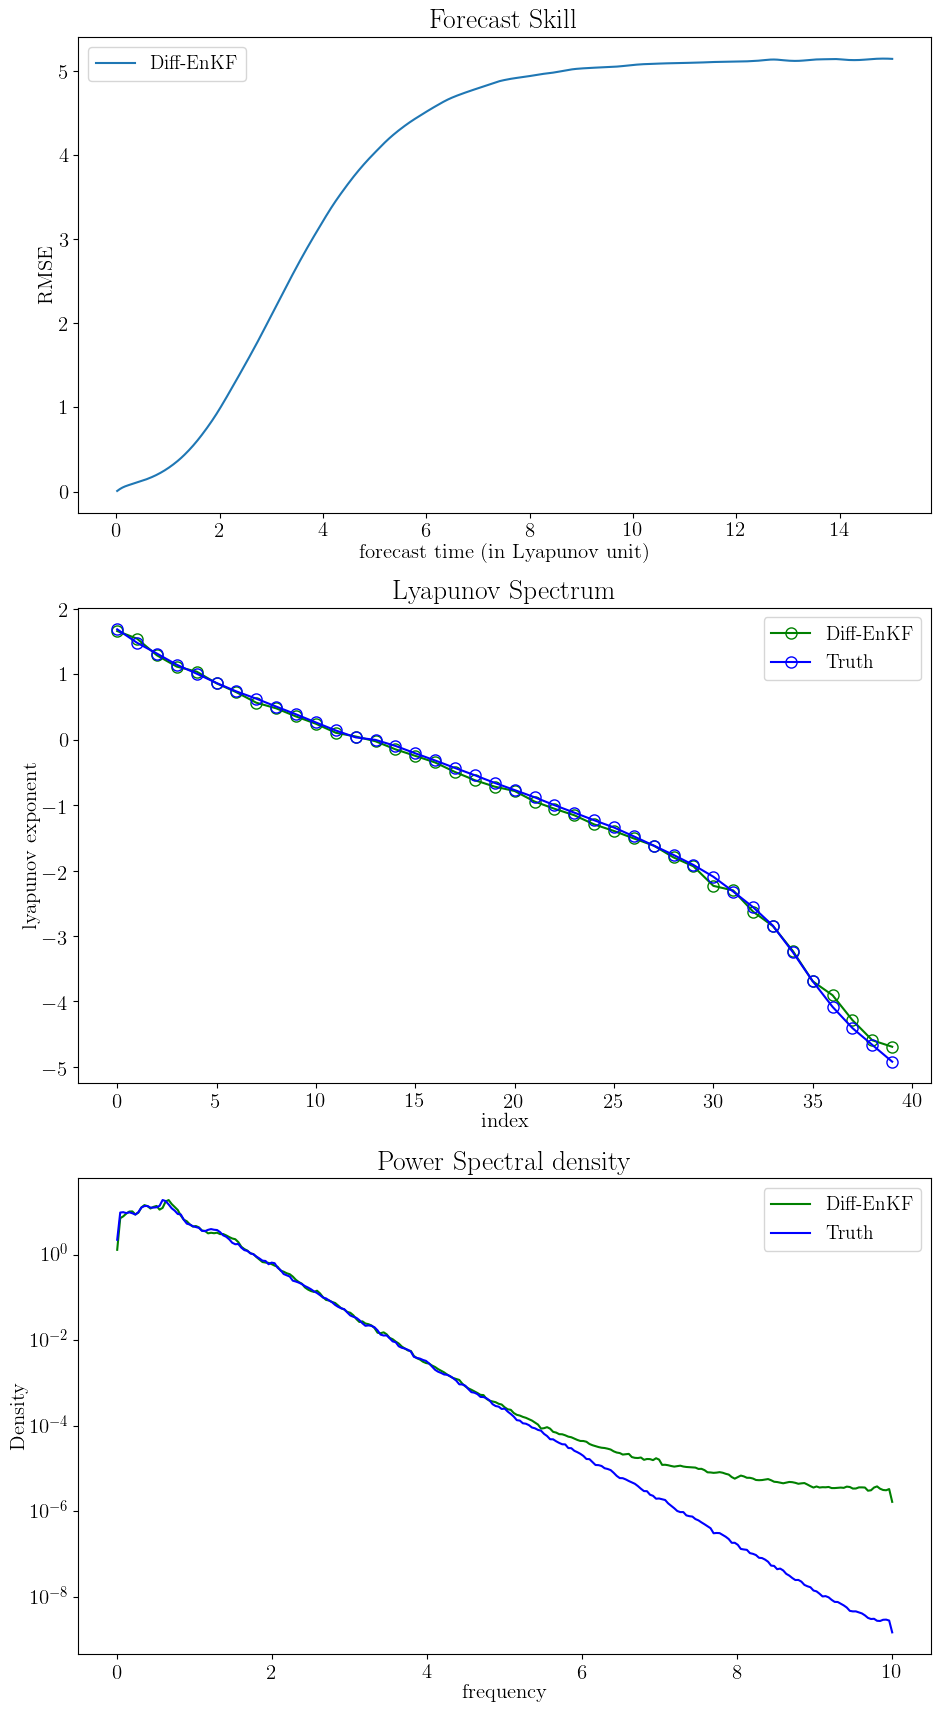

time: 875 ms (started: 2021-06-08 09:01:38 +00:00)


In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(11, 21), constrained_layout=False)
axes[0].plot(t_test.cpu().numpy()*1.67, fs_diff.cpu().numpy(), label='Diff-EnKF')
# axes[0].plot(t_test.cpu().numpy()*1.67, fs_em.cpu().numpy(), label='EM-EnKS')
# axes[0].plot(t_test.cpu().numpy()*1.67, fs_tmp.cpu().numpy(), label='tmp')
axes[0].set_title('Forecast Skill', fontsize=20)
axes[0].set_xlabel('forecast time (in Lyapunov unit)', fontsize=15)
axes[0].set_ylabel('RMSE', fontsize=15)
axes[0].xaxis.set_tick_params(labelsize=15)
axes[0].yaxis.set_tick_params(labelsize=15)
axes[0].legend()

axes[1].plot(spec_diff,'go-',mfc='none',ms=8, label='Diff-EnKF')
# axes[1].plot(spec_em,'o-', color='orange',mfc='none',ms=8, label='EM-EnKS')
# axes[1].plot(spec_tmp, label='tmp')
axes[1].plot(spec_true,'bo-',mfc='none',ms=8, label='Truth')
axes[1].set_title("Lyapunov Spectrum", fontsize=20)
axes[1].set_xlabel('index', fontsize=15)
axes[1].set_ylabel('lyapunov exponent', fontsize=15)
axes[1].xaxis.set_tick_params(labelsize=15)
axes[1].yaxis.set_tick_params(labelsize=15)
axes[1].legend()
print(spec_diff)
# print(spec_em)
# print(spec_tmp)
print(spec_true)

axes[2].semilogy(f, Pxx_den_diff, 'g-',label='Diff-EnKF')
# axes[2].semilogy(f,  Pxx_den_em,color='orange', label='EM-EnKS')
# axes[2].semilogy(f, Pxx_den_tmp, label='tmp')
axes[2].semilogy(f,  Pxx_den_true, 'b-',label='Truth')
axes[2].set_title("Power Spectral density", fontsize=20)
axes[2].set_xlabel('frequency', fontsize=15)
axes[2].set_ylabel('Density', fontsize=15)
axes[2].xaxis.set_tick_params(labelsize=15)
axes[2].yaxis.set_tick_params(labelsize=15)
axes[2].legend()

plt.show()